# I. Introduction

## Objective

The study aims to predict whether a certain passenger onboard the Titanic would survive the disaster using their age, sex, passenger class, number of relatives onboard, and embarkment dock. Logistic regression was the instrument used to construct this particular predictive model.

## Dataset Description

The 'titanic' dataset from seaborn is a list of Titanic passengers alongside some of their important demographic data. It consists of 891 entries and 15 columns.

# II. Data Preprocessing Steps

To begin, load the 'titanic' dataset from seaborn.

In [30]:
import seaborn as sns
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Exploratory Data Analysis

#### Unnecessary Columns - embark_town, class, who, adult_male, deck, alive, alone

These columns are repetitive with other variables that are already pre-existing.

In [31]:
df_copy = df.copy()
df_copy.drop(['embark_town', 'class', 'who', 'adult_male', 'deck', 'alive', 'alone'], axis=1, inplace=True)

#### Unnecessary Columns - fare

Notice how 'fare' is practically already described by the 'pclass' variable. In fact, the 'pclass' variable should be a more reliable indicator for survival rate since aside from giving an idea of the fare price, it also properly groups the passengers according to where they were positioned inside the Titanic. In practice, 'fare' functions more as a noise in this dataset. Any substantial correlation will only be attributed to the variable being practically the same as the 'pclass' column.

In [32]:
df_copy.drop(['fare'], axis=1, inplace=True)

#### Missing - Age

In [33]:
df_copy.isnull().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
embarked      2
dtype: int64

Notice how there are missing entries in the 'age' and 'embarked' columns. We can explore their behaviors to think of strategies on how to address them.

In [34]:
import pandas as pd
from IPython.display import display

In [35]:
df1 = {
  "Statistic": ["Portion with Missing 'age' Records"],
  "Value": ['%.2f%%' %((df_copy['age'].isnull().sum()/df_copy.shape[0])*100)]
}
df1 = pd.DataFrame(df1)
display(df1.style.hide(axis="index"))

Statistic,Value
Portion with Missing 'age' Records,19.87%


There is about 20% of the 'age' column that is missing. We can take a look at a histogram of 'age' and observe how the data is distributed.

In [36]:
import matplotlib.pyplot as plt
import numpy as np

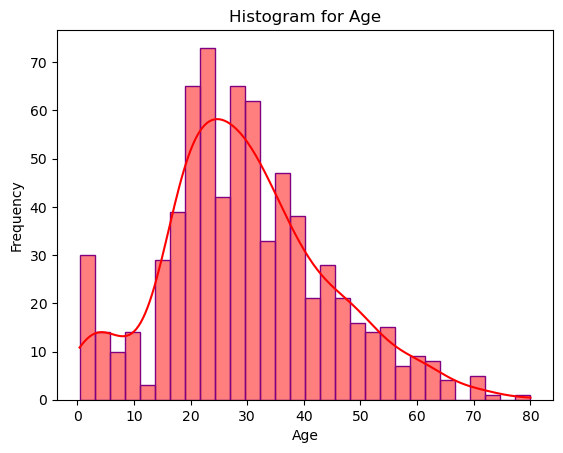

In [37]:
sns.histplot(df_copy['age'], bins=30, kde=True, color='red', edgecolor='purple')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram for Age')
plt.show()

Since the distribution has a right skew, we must look at the relationship between the response variable 'survived' and the other predictors. This helps us think of a strategy on how to impute the missing data without disturbing the existing trends in the graph.

In [38]:
df_copy_num_col = df_copy.select_dtypes(exclude=['object']).columns
df_copy_num = df_copy[df_copy_num_col]
correlation = abs(pd.DataFrame(df_copy_num.corr().survived))
correlation

,survived
survived,1.000000
pclass,0.338481
age,0.077221
sibsp,0.035322
parch,0.081629


Based on the correlations given in the table, only 'pclass' and 'fare' have substantial correlations with 'survived.' Among these, 'pclass' has the most substantial effect. Hence, we can group the 'age' column by 'pclass', take their median values, and impute them accordingly to the missing entries.

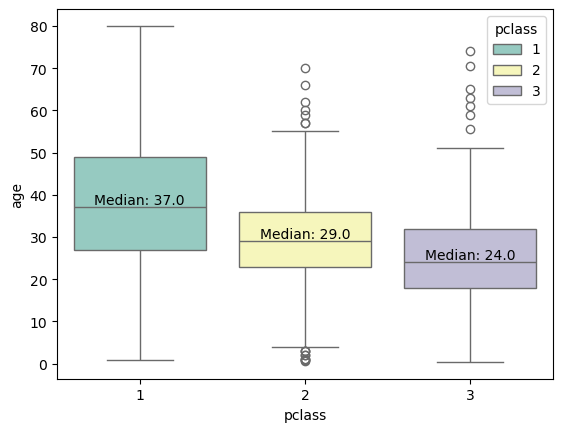

<Figure size 1000x1000 with 0 Axes>

In [39]:
fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))
sns.boxplot(x='pclass',y='age',data=df_copy,hue='pclass',palette='Set3',ax=ax)

medians = df.groupby('pclass')['age'].median()

for i, median_value in enumerate(medians):
    x_position = i
    y_position = median_value
    ax.text(x_position, y_position, f'Median: {median_value:.1f}', ha='center', va='bottom', color='black')

plt.show()

In [41]:
def impute_train_age(cols):
    age = cols.iloc[0]
    pclass = cols.iloc[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age
df_copy['age'] = df_copy[['age','pclass']].apply(impute_train_age,axis=1)

We can look at whether the imputations have been executed properly.

In [42]:
df_copy.isnull().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
embarked    2
dtype: int64

The data has been imputated properly since there are no more null values in the 'age' column.

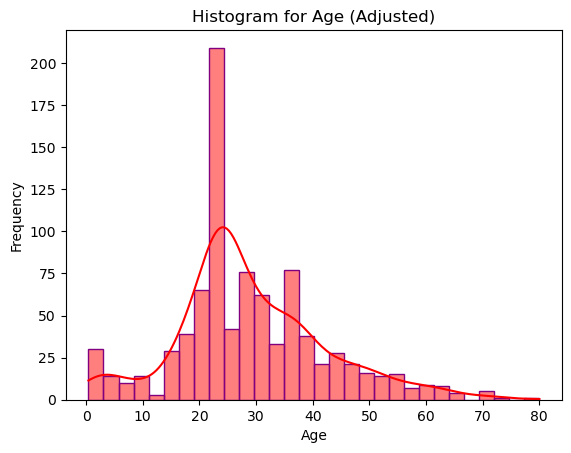

In [43]:
sns.histplot(df_copy['age'], bins=30, kde=True, color='red', edgecolor='purple')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram for Age (Adjusted)')
plt.show()

After imputation, the 'age' distribution is still very similar with the previous one.

#### Missing - embarked

Observe the proportion of missing records in the 'embarked' column.

In [44]:
df3 = {
  "Statistic": ["Portion with Missing 'embarked' Records"],
  "Value": ['%.2f%%' %((df_copy['embarked'].isnull().sum()/df_copy.shape[0])*100)]
}
df3 = pd.DataFrame(df3)
display(df3.style.hide(axis="index"))

Statistic,Value
Portion with Missing 'embarked' Records,0.22%


Since it is only 0.22%, we can simply impute them with the highest-occurring entry in the list.

In [45]:
df4 = {
  "Statistic": ["'embarked' Mode"],
  "Value": [df_copy["embarked"].mode()[0]]
}
df4 = pd.DataFrame(df4)
display(df4.style.hide(axis="index"))

Statistic,Value
'embarked' Mode,S


In this case, the 'embarkment' value with the most frequency is 'S' or Southampton.

In [46]:
df_copy["embarked"].fillna("S", inplace=True)

Verify whether the imputation has taken place.

In [47]:
df_copy.isnull().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
embarked    0
dtype: int64

Since there are no more empty 'embarked' entries, then the imputation has been executed properly.

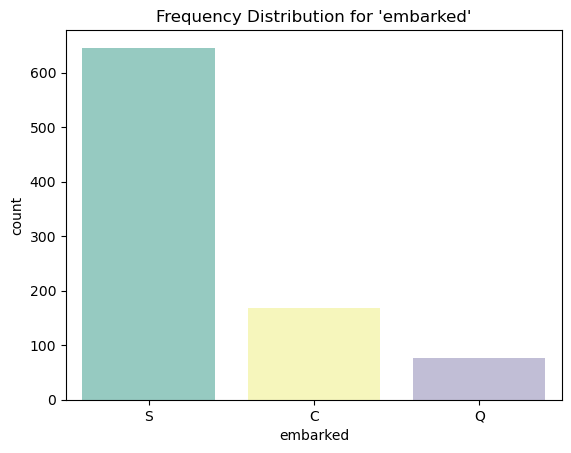

In [18]:
sns.countplot(x='embarked', data=df_copy, hue='embarked', palette='Set3')
plt.title("Frequency Distribution for 'embarked'")
plt.show()

Shown above is the frequency distribution for the 'embarked' variable. Almost all passengers boarded in Southampton, followed by Cherbourg, then lastly by Queenstown.

In [48]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   embarked  891 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


After all the data manipulation, the number of entries has not been changed and hence, the processes were executed properly.

#### Addressing Categorical Variables: One-Hot Encoding

Notice how 'age' and 'embarked' are of object data types which could be problematic for the regression model. Additionally, the 'pclass' could be split into different columns of binary entries to also aid in the model fitting process. Hence, we should one-hot encode these columns.

In [49]:
df_copy = pd.get_dummies(df_copy, columns=['sex', 'pclass', 'embarked'], dtype=int)
df_copy.head()

,survived,age,sibsp,parch,sex_female,sex_male,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,0,22.0,1,0,0,1,0,0,1,0,0,1
1,1,38.0,1,0,1,0,1,0,0,1,0,0
2,1,26.0,0,0,1,0,0,0,1,0,0,1
3,1,35.0,1,0,1,0,1,0,0,0,0,1
4,0,35.0,0,0,0,1,0,0,1,0,0,1


#### 80-20 Train-Test Split

As the final preparation for model fitting, the dataset must be split by a proportion of 80-20 corresponding to train-test sets.

In [50]:
from sklearn.model_selection import train_test_split

x = df_copy.drop('survived', axis=1)
y = df_copy['survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

# III. Model Implementation Details

We will now train a logistic regression model on the training set.

In [51]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, max_iter=200)
model.fit(x_train, y_train)

LogisticRegression(max_iter=200, random_state=0)

#### Predict whether a 31-year old male passenger traveling in third class, with no family on board, and embarked on Queenstown will survive the Titanic disaster.

In [52]:
test1 = pd.DataFrame(np.array([31,0,0,0,1,0,0,1,0,1,0]).reshape(1,-1),
                     columns=['age','sibsp','parch','sex_female','sex_male','pclass_1','pclass_2','pclass_3','embarked_C','embarked_Q','embarked_S'])

def survival(model,test):
    x = model.predict(test)[0]
    if x == 1:
        print("The passenger will survive the Titanic disaster.")
    else:
        print("The passenger will not survive the Titanic disaster.")

survival(model,test1)

The passenger will not survive the Titanic disaster.


#### Predict whether a 46-year old female passenger traveling in first class, with 1 sibling & 2 children on board, and embarked on Southampton will survive the Titanic disaster.

In [53]:
test2 = pd.DataFrame(np.array([46,1,2,1,0,1,0,0,0,0,1]).reshape(1,-1),
                     columns=['age','sibsp','parch','sex_female','sex_male','pclass_1','pclass_2','pclass_3','embarked_C','embarked_Q','embarked_S'])
survival(model,test2)

The passenger will survive the Titanic disaster.


# IV. Evaluation Results & Visualizations

In this section, the logistic regression model will be evaluated based on several performance metrics which will all be supplied with visualizations.

#### Accuracy

In [54]:
model.score(x_test, y_test)

0.7932960893854749

The accuracy score for the model is **79.33%**.

#### Precision, Recall, F1-score

In [55]:
from sklearn.metrics import classification_report

y_predicted = model.predict(x_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



The given table shows the precision, recall, and f1-score metrics of the model. Since recall is low in the alive prediction, expect a high turnout of false negatives in the confusion matrix.

#### Confusion Matrix Heatmap

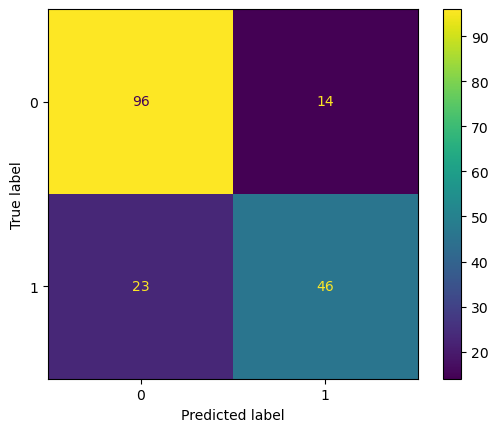

In [56]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

This confusion matrix verifies our previous assumption that there are many false negatives in the model prediction, being a value of 23 in this case.

#### ROC Curve and AUC Score

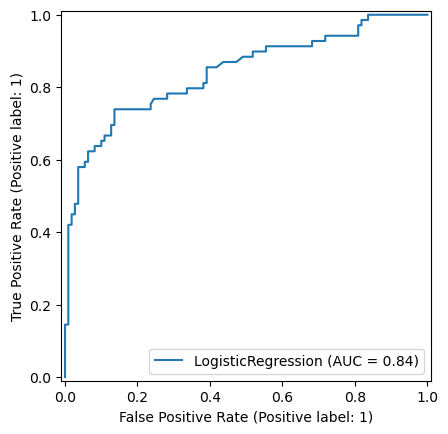

In [57]:
metrics.RocCurveDisplay.from_estimator(model, x_test, y_test)

Based on the ROC Curve, the AUC score of the model is **0.84**. This means that while not excellent, it is good enough to be a general predictor for survival.

# V. Conclusion & Future Improvements

Logistic regression was conducted to predict the survival of a passenger during the Titanic disaster using their age, sex, passenger class, number of relatives onboard, and embarkment dock. The model had an accuracy of about 79.33%, denoting a mildly strong performance. With its moderately good precision for both survival predictions, the model had a relatively low number of false positives. Furthermore, the recall score for death predictions is quite high. However, it seems to struggle with predicting survivors, having a low recall score and implying several false negatives. This is then backed up by the confusion matrix and f1-scores, for which the value in predicting death is noticeably higher than survival. Moreover, the model garnered an AUC (area under the curve) score of 0.84. In general, the model is good but struggles to predict survivors correctly in several occasions.

The model's difficulty in correctly predicting survivors suggests an imbalance in the dataset, likely due to much fewer survivors relative to deceased passengers, which skews the classification. In a real-world context, such imbalances are common in medical diagnoses or fraud detection, where correctly identifying the minority class is critical. Addressing this issue can involve techniques such as resampling to balance classes or incorporating additional predictive features which might further refine survival probabilities. Additionally, hyperparameter tuning and regularization could enhance the model's ability to generalize effectively, while feature engineering such as creating interactions between variables might uncover deeper survival trends. These improvements could help the model better capture the characteristics of survivors and reduce false negatives. As such, feature selection play a crucial part in model-fitting both in theory and in reality. In this case, the inclusion of passenger class reveals that upper-class passengers had a higher survival rate than those of a lower class. This point exacerbates the notion that people who are higher up the socioeconomic ladder could afford way more privileges in life, even down to the most dire of situations such as the Titanic disaster. Choosing which features to include allows researchers to open up new avenues for discussion and make productive discourse for many issues which affect people in their everyday lives, extending to problems of even poverty and the like.